In [1]:
from qpe import *
from numpy import log, argmin

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info(ham_func, ham_pars, ham_args, n_inp, n_layers, pars, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]

    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
   
    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)

        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        
        ### checks; should be zeros ###
        # print(norm(mat_der@v0 + mat@v0_der))
        # print(norm((ham_der@v0 + ham@v0_der) - (e0_der*v0 + e0*v0_der)))
        # print()
    
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)

        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10

        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)  

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    for j in range(len(ham_pars)): # take a density matrix from the training set
        probs = [(v0s[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        probs_der = [2*(v0s_der[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        
        expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
        expec_der = sum([ev*prob_der for ev, prob_der in zip(pars_est, probs_der)])
        disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
        
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

In [3]:
def train_pure_shots(svs, labels, n_layers, n_shots=10000, n_copies=1, n_meas=0, method="Cobyla", w_ls=1e0, w_var=1e-4,
                x0=None, options={}, save_data=False, file_name=None, fvals=[], parallel=False, batch_size=None, delta=1, gamma=0.02):

    n_inp = int(log2(len(svs[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot

    if n_meas == 0:
        n_meas = n_tot
                
    n_pars_est = 2**n_meas
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # n_tot*(2 + 3*n_layers) # cry  
    
    d_diff = 2**(n_tot - n_meas)
    svs_cop = array([reduce(kron, [sv]*n_copies) for sv in svs])

    if batch_size is None:
        batch_size = len(labels)        
    
    fval_cont = [0]

    def fun_seq(x):
        """ Faster for N>=8 """
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        inds = choice(arange(len(labels)), batch_size, replace=False)
        # svs_cop_u = [U@sv for sv in svs_cop]
        svs_cop_u = [U@sv for sv in svs_cop[inds]]
        counts_list = array([measure_z_counts_pure(sv, n_shots) for sv in svs_cop_u])
        # expecs = counts_list*x_est/n_shots
        x_est = kron_A_I_diag(x_est, d_diff)
        expecs = counts_list*x_est/np.sum(counts_list[0])
        sq_expecs = np.sum(expecs*x_est, axis=1)
        expecs = np.sum(expecs, axis=1)
        # f_ls = np.sum((expecs - array(labels))**2)
        f_ls = np.sum((expecs - labels[inds])**2)
        f_var = np.sum(sq_expecs - expecs**2)
        f = w_ls*f_ls + (w_var + delta*exp(-len(fvals)*gamma))*f_var
        fval_cont[0] = f
        return f
        
    # def fun_par(x):
    #     """ Faster for N<8 """
    #     x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    #     U = hea_cry_rzrx(n_tot, n_layers, x_ans)
    #     U_dag = U.conj().T
    #     dms_cop_u = [U@dm@U_dag for dm in dms_cop]
    #     with Pool() as pool:
    #         counts_list = array(pool.map(partial(measure_z_counts, n_shots=n_shots), dms_cop_u))
    #     expecs = counts_list*x_est/n_shots
    #     sq_expecs = np.sum(expecs*x_est, axis=1)
    #     expecs = np.sum(expecs, axis=1)
    #     f_ls = np.sum((expecs - array(labels_train))**2)
    #     f_var = np.sum(sq_expecs - expecs**2)
    #     f = w_ls*f_ls + w_var*f_var
    #     fval_cont[0] = f
    #     return f
    
    if parallel==True:
        fun = fun_par
    else:
        fun = fun_seq
    
    if file_name is None and save_data == True:
        path = "/home/kardashin/Work/QPE/Results/Entanglement/Shots/"
        file_info = "c=%d-m=%d=l=%d-s=%d-w_ls=%f-w_var=%f-T=%d" %(n_copies, n_meas, n_layers, n_shots, w_ls, w_var, len(labels))
        # task_info = "-ent_rand_mixed"
        file_name = path + file_info #+ task_info 
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\tIteration: %d | Cost: %.8f | w_var: %.8f" %(len(fvals), fval_cont[0], (w_var + exp(-len(fvals)*gamma))), end="\r")
        if save_data == True:
            np.save(file_name + "-pars", x)
            np.save(file_name + "-fvals", fvals)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(None, None)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)
    # optimization_result = spsa.minimize(fun, x0)
    
    return fvals, optimization_result

In [4]:
def estimate_shots_pure(svs, labels, n_layers, pars, n_shots, n_copies=1, n_meas=0, n_est=1):
        
    n_inp = int(log2(len(svs[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    pars_est = kron_A_I_diag(pars_est, d_diff)
    

    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    svs_cop_u = [reduce(kron, [U@sv]*n_copies) for sv in svs]
    
    preds = []
    errors = []
    for e in range(n_est):
        print("\t\tEstimation run: %d" %e, end="\r")
        preds_e = []
        errors_e = []
        for j in range(len(svs)):
            counts = measure_z_counts_pure(svs_cop_u[j], n_shots)
            # pred_j = np.sum(counts*pars_est)/n_shots
            pred_j = np.sum(counts*pars_est)/np.sum(counts)
            if np.sum(counts) != n_shots:
                print("пашол нахуй")
            error_j = (pred_j - labels[j])**2
            preds_e.append(pred_j)
            errors_e.append(error_j)
        preds.append(array(preds_e))
        errors.append(array(errors_e))

    # for e in range(n_est):
    #     print("\t\tEstimation run: %d" %e, end="\r")
    #     counts_list = array([measure_z_counts_pure(sv, n_shots) for sv in svs_cop_u])
    #     preds_e = counts_list*pars_est/n_shots
    #     errors_e = (preds_e - labels)**2
    #     preds.append(array(preds_e))
    #     errors.append(array(errors_e))  
        
    return array(preds), array(errors)

### Settings

In [5]:
ham_func = ising_ham
# ham_func = schwinger_ham

ham_args = []

(0.01, 2.0)

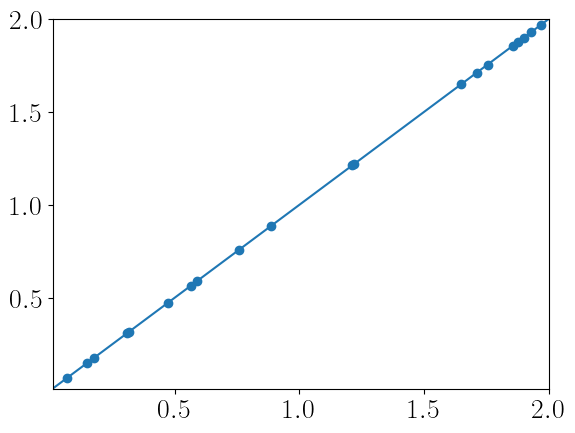

In [31]:
n_inp = 4
a = 1e-2
b = 2
T = 20

# labels_train = linspace(a, b, T)
labels_train = np.sort(uniform(a, b, T))
svs_train = []
for p in labels_train:
    ham = ham_func(n_inp, p, *ham_args)
    svs_train.append(eigh(ham)[1][:,0])

plt.scatter(labels_train, labels_train)
plt.plot(linspace(a, b), linspace(a, b))
plt.xlim(a, b)
plt.ylim(a, b)

In [32]:
V = 51
labels_test = linspace(a, b, V)
svs_test = []
for p in labels_test:
    print(p, end="\r")
    ham = ham_func(n_inp, p, *ham_args)
    svs_test.append(eigh(ham)[1][:,0])

2.060200000000000234

## Many runs

#### two

In [38]:
n_copies = 1
n_tot = n_inp*n_copies
n_meas = 2#n_inp*n_copies
n_layers = 7
n_shots_list = [2**i for i in range(6, 15)][::2]# [100, 1000, 10000]
n_runs = 10
w_ls = 1
w_var = 1e-4
method = "COBYQA"
options = {"maxiter": 5000}#, "maxfun": 1000000}
dp = 1e-5
# x0_list = [[concatenate([uniform(0, 2*pi, (3*n_tot - 1)*n_layers + 2*n_tot), normal(0., 1, 2**n_meas)]) for r in range(n_runs)] for s in range(len(n_shots_list))]
x0_list = [[concatenate([normal(pi, 0.1, (3*n_tot - 1)*n_layers + 2*n_tot), normal(0., 0.1, 2**n_meas)]) for r in range(n_runs)] for s in range(len(n_shots_list))]

In [39]:
path = "/home/kardashin/Work/QPE/Results/Ising/Measurements/"
pref = ("c=%d-m=%d-l=%d-w_ls=%.1f-w_var=%.4f-s=%s-%s" %(n_copies, n_meas, n_layers, w_ls, w_var, n_shots_list, method)).replace(" ", "")
path + pref

'/home/kardashin/Work/QPE/Results/Ising/Measurements/c=1-m=2-l=7-w_ls=1.0-w_var=0.0001-s=[64,256,1024,4096,16384]-COBYQA'

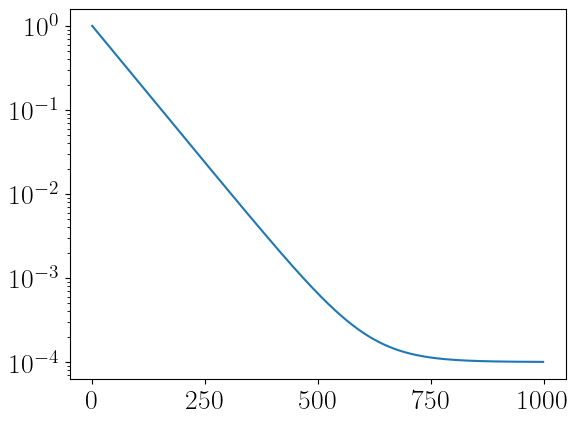

In [40]:
delta = 1
gamma = 0.015
plt.plot([1e-4 + delta*exp(-i*gamma) for i in range(1000)])
plt.yscale("log")

In [41]:
fvals_list = []
fval_fin_list = []
results_list = []
times_list = []
for s in range(len(n_shots_list)):
    print("n_shots:", n_shots_list[s])
    fvals_r_list = []
    fval_fin_r_list = []
    results_r_list = []
    times_r_list = []
    for r in range(n_runs):
        print("\tr:", r)

#         print("\t\tPre-training with w_var=1")
#         time_start_r = time()
#         fvals_pt, result_pt = train_pure_shots(svs_train, labels_train, n_layers, n_shots=n_shots_list[s], n_copies=n_copies, n_meas=n_meas, method=method, w_ls=w_ls, w_var=1, x0=x0_list[s][r], options=options, fvals=[])
#         print("\n\t\tTraining")
#         fvals_r, result_r = train_pure_shots(svs_train, labels_train, n_layers, n_shots=n_shots_list[s], n_copies=n_copies, n_meas=n_meas, method=method, w_ls=w_ls, w_var=w_var, x0=result_pt.x, options=options, fvals=fvals_pt)
#         time_finish_r = time() - time_start_r
        
        print("\t\tTraining")
        time_start_r = time()
        fvals_r, result_r = train_pure_shots(svs_train, labels_train, n_layers, n_shots=n_shots_list[s], n_copies=n_copies, n_meas=n_meas, method=method, w_ls=w_ls, w_var=w_var, x0=x0_list[s][r], options=options, gamma=gamma, fvals=[])
        time_finish_r = time() - time_start_r
        
        print()
        print("\t\tFinished in", time_finish_r)
        print("\t\t", result_r.message)
        print("\t\tCost:", result_r.fun)
        fvals_r_list.append(fvals_r)
        fval_fin_r_list.append(result_r.fun)
        results_r_list.append(result_r)
        times_r_list.append(time_finish_r)
    print("\tMin cost:", min(fval_fin_r_list))
    fvals_list.append(fvals_r_list)
    fval_fin_list.append(fval_fin_r_list)
    results_list.append(results_r_list)
    times_list.append(times_r_list)

n_shots: 64
	r: 0
		Training
		Iteration: 1690 | Cost: 2.30129343 | w_var: 0.00010000
		Finished in 259.75800800323486
		 The lower bound for the trust-region radius has been reached
		Cost: 1.4648092697843416
	r: 1
		Training
		Iteration: 1662 | Cost: 0.72573252 | w_var: 0.00010000
		Finished in 171.39160776138306
		 The lower bound for the trust-region radius has been reached
		Cost: 0.2395041859391831
	r: 2
		Training
		Iteration: 1747 | Cost: 1.29939239 | w_var: 0.00010000
		Finished in 89.40155172348022
		 The lower bound for the trust-region radius has been reached
		Cost: 0.22559501657521194
	r: 3
		Training
		Iteration: 1836 | Cost: 1.20894044 | w_var: 0.00010000
		Finished in 91.87886500358582
		 The lower bound for the trust-region radius has been reached
		Cost: 0.7400589016710777
	r: 4
		Training
		Iteration: 1668 | Cost: 1.21293728 | w_var: 0.00010000
		Finished in 87.20597505569458
		 The lower bound for the trust-region radius has been reached
		Cost: 0.6613019911231743


In [88]:
np.save(path + pref + "-fvals_list", array(fvals_list, dtype=object))
np.save(path + pref + "-fval_fin_list", array(fval_fin_list))
np.save(path + pref + "-results_list", results_list)
np.save(path + pref + "-times_list", array(times_list))
# np.save(path + pref + "-fvals_inf", array(fvals_inf))
# np.save(path + pref + "-result_inf", result_inf)
np.save(path + pref + "-labels_train", labels_train)

In [42]:
# """ mind the initials! """
# fvals_inf, result_inf = train_pure(svs_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method="BFGS", 
#                               w_ls=w_ls, w_var=w_var, x0=results_list[-1][-1].x, options={"maxiter": 10e10}, fvals=[])
# #                               w_ls=w_ls, w_var=w_var, x0=pars_inf, options={"maxiter": 1000})
# pars_inf = result_inf.x

# dp=1e-6
# expecs_train_inf, expecs_der_train_inf, disps_train_inf, CFIs_train_inf, QFIs_train_inf = aux_info(ham_func, labels_train, 
#                                                                                                    ham_args, n_inp, n_layers, pars_inf,
#                                                                                                    n_copies=n_copies, n_meas=n_meas, dp=dp)
# expecs_test_inf, expecs_der_test_inf, disps_test_inf, CFIs_test_inf, QFIs_test_inf = aux_info(ham_func, labels_test, 
#                                                                                               ham_args, n_inp, n_layers, pars_inf,
#                                                                                               n_copies=n_copies, n_meas=n_meas, dp=dp)
# biass_train_inf = expecs_train_inf - labels_train
# biass_test_inf = expecs_test_inf - labels_test
# print("\nTesting MSE:", np.sum((expecs_test_inf - labels_test)**2))

			Iteration: 6221 | Cost: 0.01974101 | Time passed: 1139 s
Testing MSE: 0.02464610004952844


In [43]:
n_est = 100
# preds_train_list, expecs_train_list, expecs_der_train_list, disps_train_list, errors_train_list, CFIs_train_list, QFIs_train_list = [], [], [], [], [], [], []
preds_test_list, expecs_test_list, expecs_der_test_list, disps_test_list, errors_test_list, CFIs_test_list, QFIs_test_list = [], [], [], [], [], [], []
for s in range(len(n_shots_list)):
    print("n_shots:", n_shots_list[s])
    n_shots = n_shots_list[s]
    preds_test_list_r, expecs_test_list_r, expecs_der_test_list_r, disps_test_list_r, errors_test_list_r, CFIs_test_list_r, QFIs_test_list_r = [], [], [], [], [], [], []
    for ind in range(n_runs):
        print("\tind:", ind)
        pars = results_list[s][ind].x
        
        print("\t\tTraining data")
        preds_train, errors_train = estimate_shots_pure(svs_train, labels_train, n_layers, pars, n_shots, n_est=n_est, n_copies=n_copies, n_meas=n_meas)
        expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(ham_func, labels_train, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)                                                           
        
        print("\n\t\tTesting data")
        preds_test, errors_test = estimate_shots_pure(svs_test, labels_test, n_layers, pars, n_shots, n_est=n_est, n_copies=n_copies, n_meas=n_meas)
        expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(ham_func, labels_test, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)
        
        print("\n\t\tMean testing MSE:", np.mean(np.sum(errors_test, axis=1)))
        print("\t\tMin testing MSE: ", np.min(np.sum(errors_test, axis=1)))
        
        # preds_train_list.append(preds_train)
        # expecs_train_list.append(expecs_train)
        # errors_train_list.append(errors_train)
        # expecs_der_train_list.append(expecs_der_train)
        # disps_train_list.append(disps_train)
        # CFIs_train_list.append(CFIs_train)
        # QFIs_train_list.append(QFIs_train)
        
        preds_test_list_r.append(preds_test)
        expecs_test_list_r.append(expecs_test)
        errors_test_list_r.append(errors_test)
        expecs_der_test_list_r.append(expecs_der_test)
        disps_test_list_r.append(disps_test)
        CFIs_test_list_r.append(CFIs_test)
        QFIs_test_list_r.append(QFIs_test)

    preds_test_list.append(preds_test_list_r)
    expecs_test_list.append(expecs_test_list_r)
    errors_test_list.append(errors_test_list_r)
    expecs_der_test_list.append(expecs_der_test_list_r)
    disps_test_list.append(disps_test_list_r)
    CFIs_test_list.append(CFIs_test_list_r)
    QFIs_test_list.append(QFIs_test_list_r)

n_shots: 64
	ind: 0
		Training data
		Estimation run: 99
		Testing data
		Estimation run: 99
		Mean testing MSE: 3.9724095681316824
		Min testing MSE:  3.1209702907107753
	ind: 1
		Training data
		Estimation run: 99
		Testing data
		Estimation run: 99
		Mean testing MSE: 2.3034940972461837
		Min testing MSE:  1.3663703031003798
	ind: 2
		Training data
		Estimation run: 99
		Testing data
		Estimation run: 99
		Mean testing MSE: 2.130742951573737
		Min testing MSE:  1.248499516623254
	ind: 3
		Training data
		Estimation run: 99
		Testing data
		Estimation run: 99
		Mean testing MSE: 2.8881679009027095
		Min testing MSE:  2.0398257133886766
	ind: 4
		Training data
		Estimation run: 99
		Testing data
		Estimation run: 99
		Mean testing MSE: 3.0663844782327114
		Min testing MSE:  2.0247676874619427
	ind: 5
		Training data
		Estimation run: 99
		Testing data
		Estimation run: 99
		Mean testing MSE: 4.159286527252068
		Min testing MSE:  2.91536137743252
	ind: 6
		Training data
		Estimation ru

In [44]:
nfev_list = []
for s in range(len(n_shots_list)):
    nfev_list_r = []
    for r in range(n_runs):
        nfev = results_list[s][r].nfev
        nfev_list_r.append(nfev)
    nfev_list.append(nfev_list_r)

n_inp: 4 | n_meas: 2 | n_layers: 7 | method: COBYQA


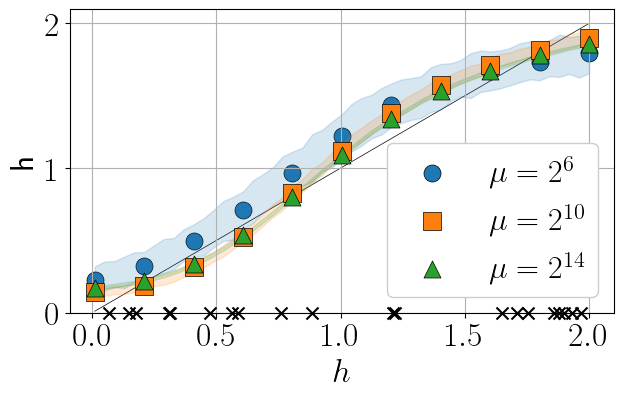

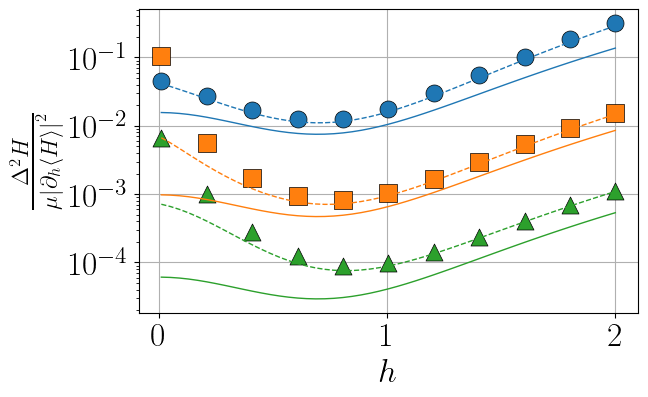

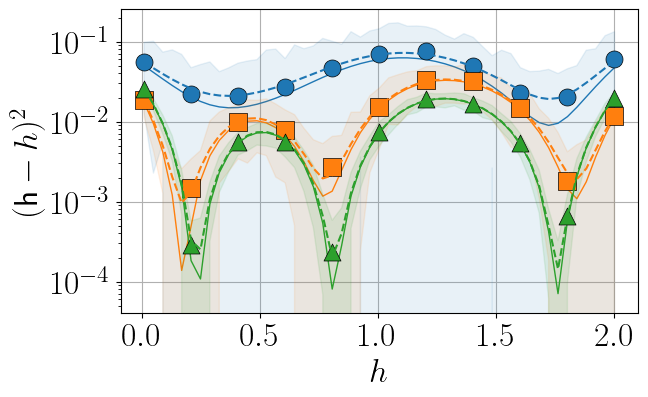

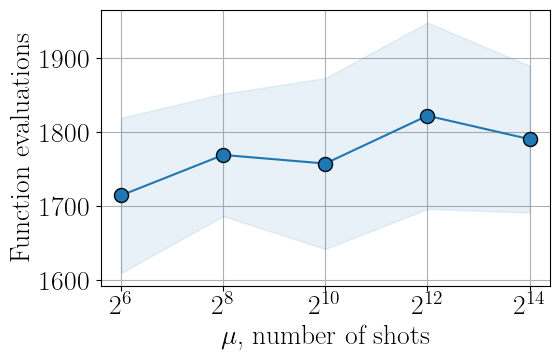

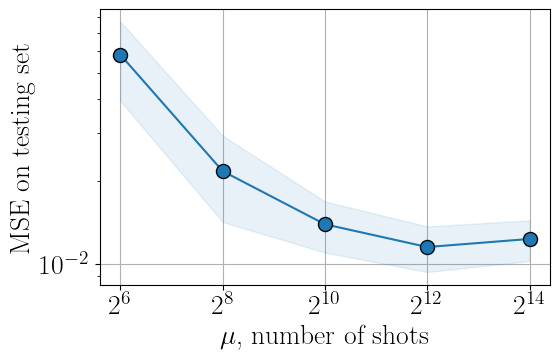

In [46]:
print("n_inp: %d | n_meas: %d | n_layers: %d | method: %s" %(n_inp, n_meas, n_layers, method))

matplotlib.rcParams.update({'font.size': 24})

markers = ["o", "s", "s", "d", "^", "P"]
colors = ["C0", "C1", "C1", "C3", "C2", "C5"]

me = 5

ind_list = [0, 2, 4]

plt.figure(figsize=(7, 4.5))
# for s in range(len(n_shots_list)):
for s in ind_list:
    ind = argmin(fval_fin_list[s])
    yest = np.mean(preds_test_list[s][ind], axis=0)
    yerr = std(preds_test_list[s][ind], axis=0)
    label = r"$\mu=2^{%d}$"%(int(np.log2(n_shots_list[s]))) # r"$\mu=%d$"%n_shots_list[s]
    plt.scatter(labels_test[::me], yest[::me], s=150, zorder=s, ec="black", linewidth=0.5, marker=markers[s], color=colors[s], label=label)
    plt.fill_between(labels_test, yest - yerr, yest + yerr, color=colors[s], alpha=0.175, linewidth=1)
    # plt.errorbar(labels_test, yest, yerr=yerr, capsize=2, zorder=s, marker=markers[s], label=r"$\mu=%d$"%n_shots_list[s])
# plt.scatter(labels_test[::me], expecs_test_inf[::me], s=120, zorder=s, ec="black", linewidth=0.5, marker=markers[-1], color=colors[-1], label=r"$\mu=\infty$")
plt.plot(labels_test, labels_test, color="black", linewidth=0.5, zorder=-1)
plt.scatter(labels_train, [0]*T, color="black", s=75, marker="x", clip_on=False, zorder=10) # , label="Training data"
plt.xlabel(r"$h$")
plt.ylabel(r"$\mathsf{h}$")
plt.grid(zorder=0)
plt.legend(framealpha=1, fontsize=23, ncol=1)
plt.ylim(ymin=0)
plt.tight_layout()
# plt.savefig(path + pref + "/" + "ising-shots-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

mu_inf = 1e8

plt.figure(figsize=(7, 4.5))
# for s in range(len(n_shots_list)):
for s in ind_list:
    ind = argmin(fval_fin_list[s])
    plt.scatter(labels_test[::me], n_copies*disps_test_list[s][ind][::me]/expecs_der_test_list[s][ind][::me]**2/n_shots_list[s], s=150, zorder=10, marker=markers[s], color=colors[s], ec="black", linewidth=0.5) # , label=r"$\mu=\infty$"
    plt.plot(labels_test, 1/CFIs_test_list[s][ind]/n_shots_list[s], color=colors[s], linestyle="--", label=r"$\frac{1}{I_c}$", linewidth=1, zorder=s+11)
    plt.plot(labels_test, 1/QFIs_test_list[s][ind]/n_shots_list[s], color=colors[s], label=r"$\frac{1}{I_q}$", linewidth=1, zorder=s+11)
# plt.scatter(labels_test[::me], n_copies*disps_test_inf[::me]/expecs_der_test_inf[::me]**2/mu_inf, s=120, zorder=10, marker=markers[-1], color=colors[-1], ec="black", linewidth=0.5) # , label=r"$\mu=\infty$"
# plt.plot(labels_test, 1/QFIs_test_inf/mu_inf, color=colors[-1], label=r"$\frac{1}{I_q}$", linewidth=1, zorder=s+11)
plt.xlabel(r"$h$")
plt.ylabel(r"$\frac{\Delta^2 H}{\mu\left|\partial_h \langle H \rangle \right|^2}$" )
# plt.ylim(ymin=1e-6, ymax=1e-1)
plt.grid(zorder=0)
plt.yscale("log")
plt.tight_layout()
# plt.savefig(path + pref + "/" + "ising-shots-var.pdf", transparent=True, bbox_inches='tight')
plt.show()



# plt.figure(figsize=(8, 5))
# plt.scatter(labels_test[::me], n_copies*disps_test_inf[::me]/expecs_der_test_inf[::me]**2, s=120, zorder=10, marker=markers[-1], color=colors[-1], ec="black", linewidth=0.5) # , label=r"$\mu=\infty$"
# plt.plot(np.sort(labels_test), n_copies/CFIs_test_inf, color=colors[-1], linewidth=1.5, linestyle="dashed", label=r"$\frac{1}{I_c}$") # , color="tab:red"
# plt.plot(np.sort(labels_test), n_copies/QFIs_test_inf, color=colors[-1], linewidth=3, linestyle="solid", label=r"$\frac{1}{I_q}$") # , color="tab:blue", label=r"$\frac{1}{I_q}$"
# plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
# plt.xlabel(r"$\alpha$")
# plt.grid(zorder=0)
# plt.legend(framealpha=1, fontsize=19)
# plt.tight_layout()
# # plt.savefig(path + pref + "-var_inf.pdf", transparent=True, bbox_inches='tight')
# plt.show()


plt.figure(figsize=(7, 4.5))
# for s in range(len(n_shots_list)):
for s in ind_list:
    ind = argmin(fval_fin_list[s])
    biass_test = expecs_test_list[s][ind] - labels_test
    yest = mean(errors_test_list[s][ind], axis=0)
    yerr = std(errors_test_list[s][ind], axis=0)
    plt.plot(labels_test, disps_test_list[s][ind]/n_shots_list[s] + biass_test**2, color=colors[s], linewidth=1.5, linestyle="--", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=s+14)
    plt.scatter(labels_test[::me], yest[::me], marker=markers[s], color=colors[s], s=150, ec="black", linewidth=0.5, zorder=s+13)
    plt.fill_between(labels_test, yest - yerr, yest + yerr, color=colors[s], alpha=0.1, linewidth=1, zorder=s+10)
    plt.plot(labels_test, expecs_der_test_list[s][ind]**2/QFIs_test_list[s][ind]/n_shots_list[s] + biass_test**2, color=colors[s], label=r"$\frac{\left| \partial_h \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=1, zorder=s+11)
# plt.plot(labels_test, biass_test_inf**2, color=colors[-1], label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=1, zorder=s+11)
plt.xlabel(r"$h$")
plt.ylabel(r"$(\mathsf{h} - h)^2$")
# lines = [Line2D([0], [0], color="black", linewidth=3, linestyle='--'),
#          Line2D([0], [0], color="black", linewidth=3, linestyle='-')]
# labels = [r"$\frac{\Delta^2 H}{\mu} + b^2$",
#           r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$"]
# plt.legend(lines, labels, framealpha=1, fontsize=19)#, bbox_to_anchor=(0.19, 0.595), loc="center") # (0.375, 0.8)
# plt.ylim(ymin=1e-4)
plt.grid(zorder=0)
plt.yscale("log")
plt.tight_layout()
# plt.savefig(path + pref + "/" + "ising-shots-bais.pdf", transparent=True, bbox_inches='tight')
plt.show()

matplotlib.rcParams.update({'font.size': 20})

xdata = arange(len(n_shots_list))
ydata = np.mean(nfev_list, axis=1)
yerr = np.std(nfev_list, axis=1)
plt.figure(figsize=(6, 4))
plt.plot(xdata, ydata)
plt.scatter(xdata, ydata, marker="o", s=102, ec="black", linewidth=1, linestyle="-", zorder=10)
plt.fill_between(xdata, ydata - yerr, ydata + yerr, color="C0", alpha=0.1, linewidth=1, zorder=s+10)
# plt.fill_between(xdata, np.min(nfev_list, axis=1), np.max(nfev_list, axis=1), color="C0", alpha=0.175, linewidth=1, zorder=s+10)
plt.xticks(xdata, [r"$2^{%d}$"%(int(np.log2(n_shots))) for n_shots in n_shots_list])
# plt.yscale("log")
plt.xlabel(r"$\mu$, number of shots")
plt.ylabel(r"Function evaluations")
plt.grid()
plt.tight_layout()
# plt.savefig(path + pref + "/" + "ising-shots-fvals.pdf", transparent=True, bbox_inches='tight')
plt.show()

xdata = arange(len(n_shots_list))
ydata = array([mean([np.sum(errors_test_list[s][r], axis=1)/V for r in range(n_runs)]) for s in range(len(n_shots_list))])
yerr = array([std([np.sum(errors_test_list[s][r], axis=1)/V for r in range(n_runs)]) for s in range(len(n_shots_list))])
plt.figure(figsize=(6, 4))
plt.plot(xdata, ydata)
plt.scatter(xdata, ydata, marker="o", s=102, ec="black", linewidth=1, linestyle="-", zorder=10)
plt.fill_between(xdata, ydata - yerr, ydata + yerr, color="C0", alpha=0.1, linewidth=1, zorder=s+10)
# plt.fill_between(xdata, np.min(nfev_list, axis=1), np.max(nfev_list, axis=1), color="C0", alpha=0.175, linewidth=1, zorder=s+10)
plt.xticks(xdata, [r"$2^{%d}$"%(int(np.log2(n_shots))) for n_shots in n_shots_list])
# plt.yscale("log")
plt.xlabel(r"$\mu$, number of shots")
plt.ylabel(r"MSE on testing set")
plt.yscale("log")
plt.grid()
plt.tight_layout()
# plt.savefig(path + pref + "/" + "ising-shots-mse.pdf", transparent=True, bbox_inches='tight')
plt.show()

n_inp: 8 | n_meas: 2 | n_layers: 7 | method: dogbox


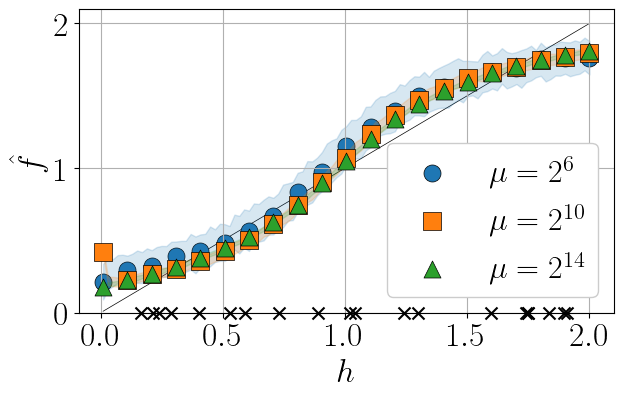

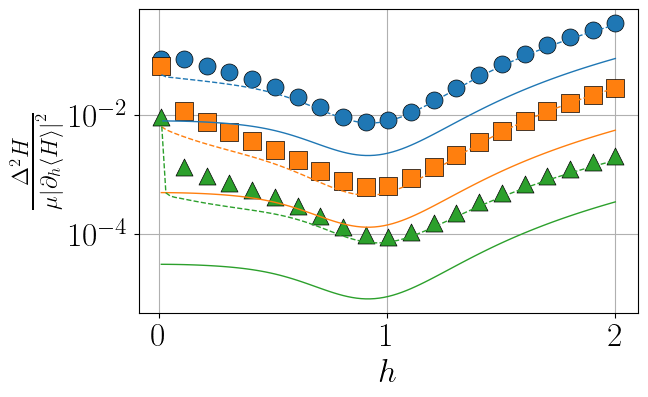

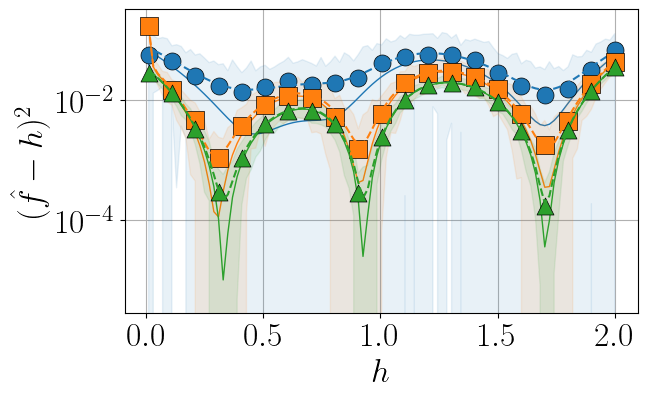

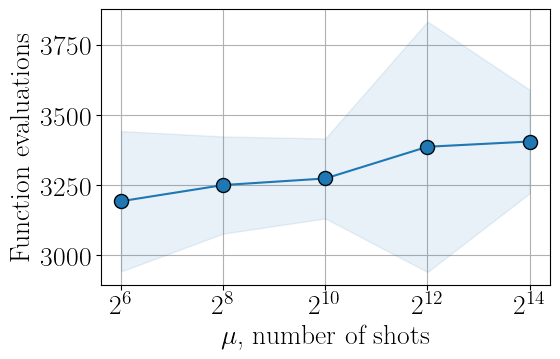

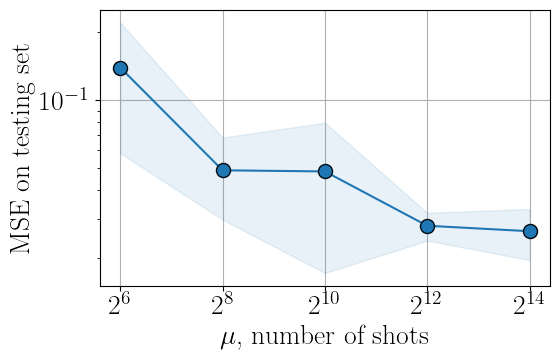

## Sigle run

In [33]:
n_copies = 1
n_tot = n_inp*n_copies
n_meas = n_inp*n_copies
n_layers = 2

w_ls = 1e0
w_var = 1e-4

dp = 1e-5

# x0 = concatenate([normal(pi, 0.01, n_tot*(2 + 3*n_layers)), normal(0., 0.01, 2**n_meas)])
# x0 = concatenate([uniform(0, 2*pi, (3*n_layers + 2)*n_inp*n_copies), normal(0., 1, 2**n_meas)])
x0 = None
# x0 = array(pars)

In [34]:
n_shots = 10000
method = "COBYQA"
options = {"maxiter": 100000, "maxfun": 1000000}

time_start = time()
fvals, result = train_pure_shots(svs_train, labels_train, n_layers, n_shots=n_shots, n_copies=n_copies, n_meas=n_meas, method=method, w_ls=w_ls, w_var=w_var, x0=x0, options=options, fvals=[])
time_finish = time() - time_start
print("\nFinished in", time_finish)
print("Cost:", result.fun)
print(result.message)
pars = result.x

/tmp/ipykernel_102591/2799838804.py:87: OptimizeWarning: Unknown solver options: maxfun
  optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)


		Iteration: 985 | Cost: 0.13546459 | w_var: 0.000100004
Finished in 156.80631566047668
Cost: 0.09042660518855775
The lower bound for the trust-region radius has been reached


n_inp: 4 | n_copies: 1 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

MSE test: 0.009581467708672565
VAR test: 2.5304740923270184
fval train: 0.12220638540129976


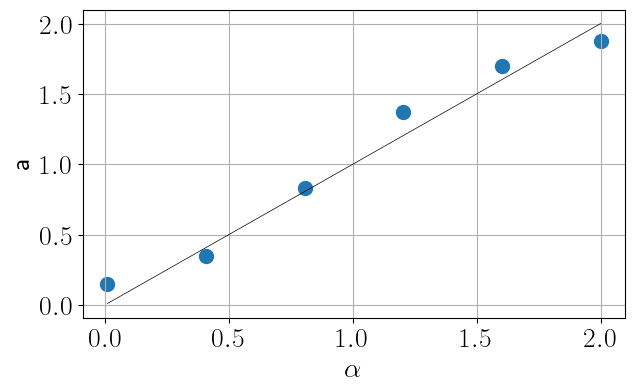

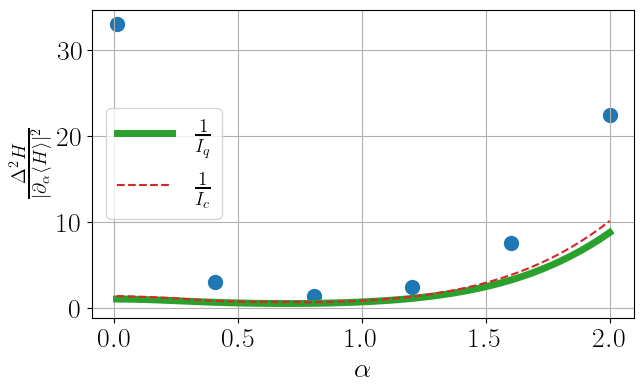

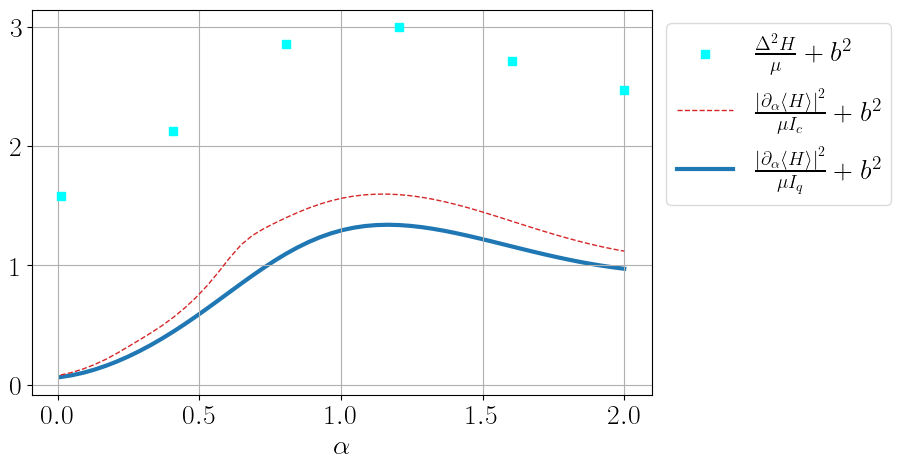

In [35]:
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(ham_func, labels_train, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(ham_func, labels_test, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)
biass_train = expecs_train - labels_train
biass_test = expecs_test - labels_test

print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("\nMSE test:", sum((labels_test - expecs_test)**2)/V)
print("VAR test:", sum(disps_test)/V)
print("fval train:", w_ls*sum((labels_train - expecs_train)**2) + w_var*sum(disps_train))

me = 10

plt.figure(figsize=(7, 4))
plt.scatter(labels_test[::me], expecs_test[::me], s=100)
plt.plot(labels_test[::me], labels_test[::me], color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
# plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test[::me], disps_test[::me]/expecs_der_test[::me]**2, s=100)
plt.plot(np.sort(labels_test), 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_test), 1/CFIs_test, color="C3", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
plt.show()

mu = 1e0
plt.figure(figsize=(8, 5))
plt.scatter(labels_test[::me], disps_test[::me]/mu + biass_test[::me]**2, marker="s", color="cyan", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=4)
plt.plot(np.sort(labels_test), expecs_der_test**2/CFIs_test/mu + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$", linewidth=1, color="tab:red", linestyle="dashed")
plt.plot(np.sort(labels_test), expecs_der_test**2/QFIs_test/mu + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=3, color="tab:blue", zorder=0)
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

In [36]:
n_est = 100
preds_test, errors_test = estimate_shots_pure(svs_test, labels_test, n_layers, pars, n_copies=n_copies, n_meas=n_meas, n_shots=n_shots, n_est=n_est)

		Estimation run: 99

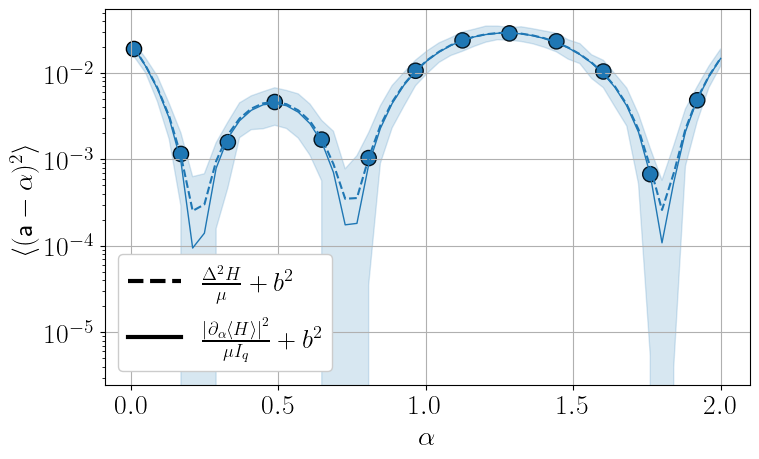

In [37]:
biass_test = expecs_test - labels_test
yest = mean(errors_test, axis=0)
yerr = std(errors_test, axis=0)

me = 4

plt.figure(figsize=(8, 5))
plt.plot(labels_test, disps_test/n_shots + biass_test**2, linewidth=1.5, linestyle="--", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", color="C0")
plt.scatter(labels_test[::me], yest[::me], s=120, linestyle="", ec="black", linewidth=0.5, color="C0")
plt.fill_between(labels_test, yest - yerr, yest + yerr, alpha=0.175, linewidth=1, color="C0")
plt.plot(labels_test, expecs_der_test**2/QFIs_test/n_shots + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle(\mathsf{a} - \alpha)^2\rangle$")
lines = [#Line2D([0], [0], color="white", marker="X", markeredgecolor="black", linewidth=0.5, markersize=10),
         Line2D([0], [0], color="black", linewidth=3, linestyle='--'),
         Line2D([0], [0], color="black", linewidth=3, linestyle='-')]
labels = [r"$\frac{\Delta^2 H}{\mu} + b^2$",
          # r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$",
          r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$"]
plt.legend(lines, labels, framealpha=1, fontsize=19)#, bbox_to_anchor=(0.19, 0.595), loc="center") # (0.375, 0.8)
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
# plt.ylim(ymin=1e-6, ymax=1e-1)
plt.grid(zorder=0)
plt.yscale("log")
plt.tight_layout()
plt.show()